## CO2 flux analysis

This script gets the raw inversion data and calculates 

### Methods:

1. Load inversion CO2 data and preprocess:
    - select roi
    - adjust units
    - set nodata
    - ...
3. Create a grouping coordinate that divides growing and non-growing seasons.   
    - This can be done manually, but consider fitting a harmonic to divide seasons.  
4. For each year and season, calculate the CO2 flux sum.
5. For each year, get the difference between growing and non-growing season.
    - This is the CO2 flux amplitude that can then be related to atmospheric CO2 and driving variables. 


In [24]:
# Get all required packages

#%%
%load_ext autoreload
%autoreload 2

# Packages
import rioxarray as rio
import os
import xarray as xr
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import geopandas as gpd

# Local modules
from mod_ra1 import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### General Settings

In [2]:
# Directories
input_dir = '../data_input/'
output_dir = '../data_output/'

# Default data properties
epsg_crs = 4326

# Chose the inversion data version. Later (shorter) time series are driven by data from more stations.
inversion = 's99'  # Inversion starting year. Options: s85, s99, s06, s10
co2inv_file = '/Users/moyanofe/BigData/GeoSpatial/Carboscope/Inversions/' + inversion + 'oc_v2022_daily.nc'

# Region files available
conts_file = os.path.join(input_dir, 'continents.geojson')
north50_file = os.path.join(input_dir, 'north50.geojson')
north30_file = os.path.join(input_dir, 'north30.geojson')
north0_file = os.path.join(input_dir, 'north0.geojson')
testrect_file = os.path.join(input_dir, 'testrect.geojson')

# Set the region to use for the analysis
roi_file = conts_file


In [3]:
# Call function for inversion CO2 preprocessing
co2fluxProc = procInvCO2(invco2_file=co2inv_file, roi_file=roi_file)

In [4]:
# Call function to get the yearly seasonal CO2 flux amplitude
co2fluxAmp = get_CO2fluxSeasAmp(co2fluxProc)

In [5]:
# Call function to calculate temporal trends, mean, variance, etc in seasonal amplitudes
co2fluxAmpStats = get_co2fluxampstats(co2fluxAmp)

/Users/moyanofe/miniconda3/envs/landcover/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/moyanofe/miniconda3/envs/landcover/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/moyanofe/miniconda3/envs/landcover/lib/python3.9/site-packages/xarray/core/nputils.py:157: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


### Save to file

In [6]:
# Saving data to file

# Saving the amp and amp-trend results to disk
file_out_amp = os.path.join(output_dir, 'co2fluxAmp_' + inversion + '.nc')
co2fluxAmp.to_netcdf(file_out_amp)

file_out_stats = os.path.join(output_dir, 'co2fluxAmpStats_' + inversion + '.nc')
co2fluxAmpStats.to_netcdf(file_out_stats)

# Save the trend data to GeoTiff (useful if reading into Earth Engine is required)
# Saving the database (not as an array) keeps the band name info. (But seems like Earth Engine does not import band names)
# file_out = os.path.join(output_dir, 'co2fluxAmpStats_Inv' + inversion + '.tif')
# co2fluxAmpStats.rio.to_raster(file_out)

# Save the co2 flux seasonal difference data to GeoTiff
# file_out = os.path.join(output_dir, 'co2fluxAmp_Inv' + inversion + '.tif')
# da_fluxamp = co2fluxAmp['co2flux_yearlyamp']
# da_fluxamp.rio.to_raster(file_out)

### Plotting

/Users/moyanofe/Work/Augsburg/Analysis/Recovery_Analysis1/scripts_local/mod_ra1.py:139: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(p1, label=co2fluxProc.isel(time=0).attrs['units'])


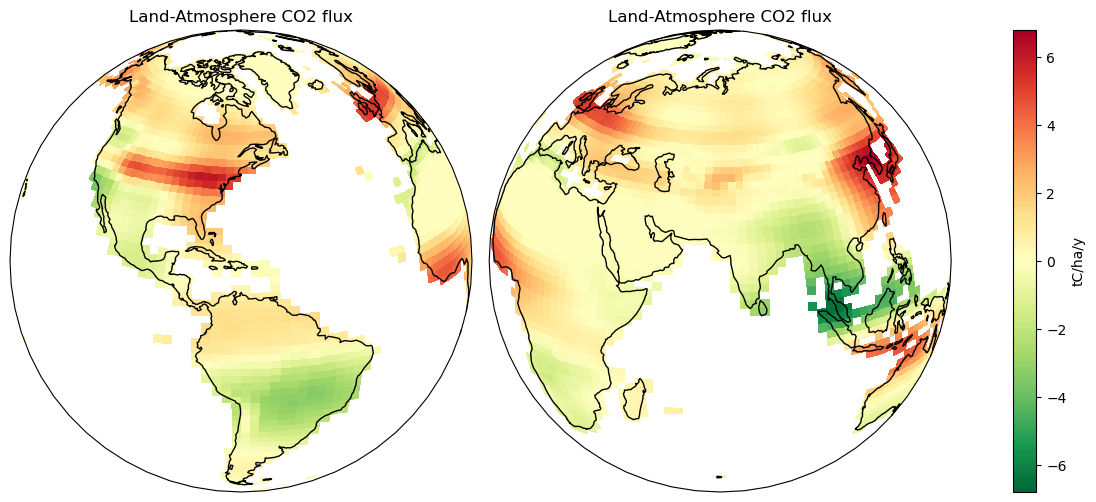

In [25]:
# Plot the first band of co2 flux rates
plotOrthographic(co2fluxProc=co2fluxProc)

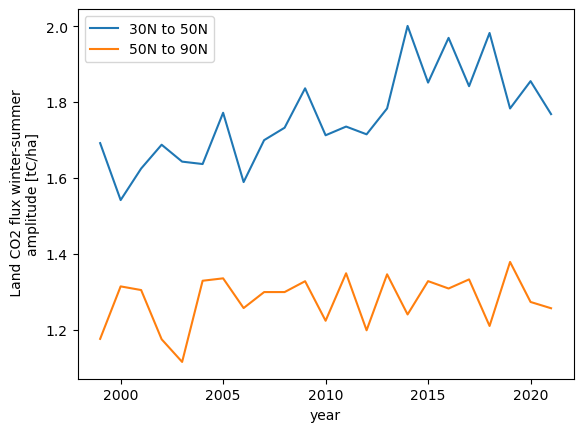

In [17]:
# Plotting of seasonal amplitude time series
plotRegMeans(co2fluxAmp=co2fluxAmp, lats=([30, 50], [50, 90]))

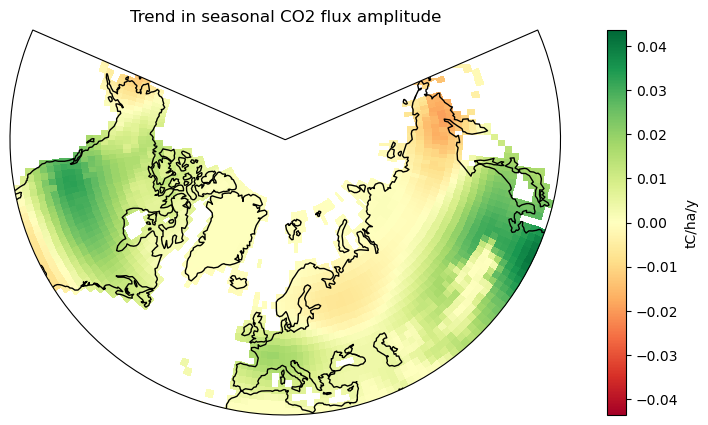

In [22]:
# Map plot of flux trends in the northern hemisphere
plotLambert(co2fluxAmpStats.slope)

/Users/moyanofe/Work/Augsburg/Analysis/Recovery_Analysis1/scripts_local/mod_ra1.py:195: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


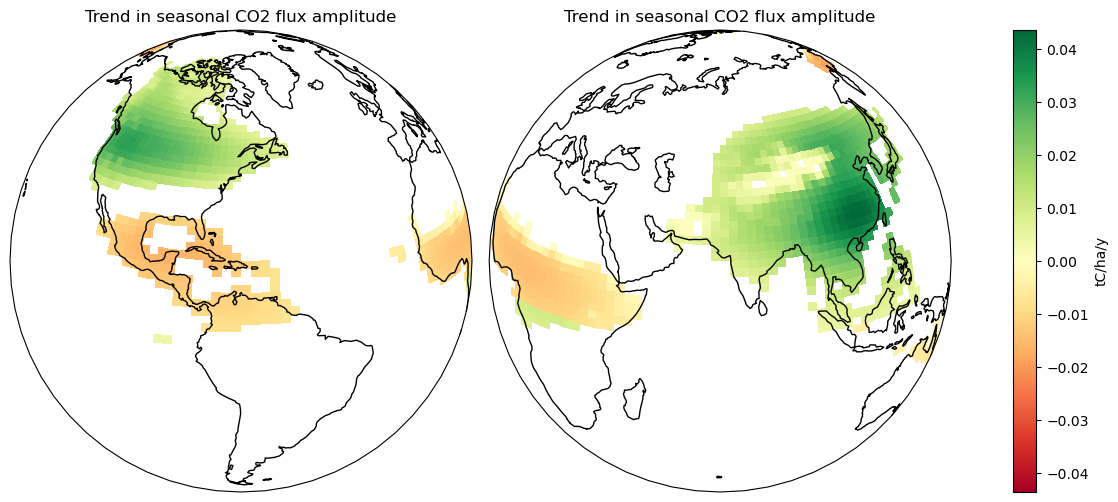

In [28]:
# Plot values with significance filter
plotOrthoSig(co2fluxAmpStats.slope, co2fluxAmpStats.p_value)